In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.

In [4]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
#     print "dt--->", dt
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2015:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year > 2011) and (dt.year < 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
# Remove dst values that are greater than 10,
# They pull in data which is not looking good 
# when we check the plots
dstDF = dstDF[ dstDF["dst_index"] <= 10. ].reset_index(drop=True)
dstDF["dtStr"] = dstDF["dst_date"].apply(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].apply(lambda x: x.strftime('%H'))
dstDF.head()

dt---> 2011-01-31 00:00:00
dt---> 2011-02-28 00:00:00
dt---> 2011-03-31 00:00:00
dt---> 2011-04-30 00:00:00
dt---> 2011-05-31 00:00:00
dt---> 2011-06-30 00:00:00
dt---> 2011-07-31 00:00:00
dt---> 2011-08-31 00:00:00
dt---> 2011-09-30 00:00:00
dt---> 2011-10-31 00:00:00
dt---> 2011-11-30 00:00:00
dt---> 2011-12-31 00:00:00
dt---> 2012-01-31 00:00:00
dt---> 2012-02-29 00:00:00
dt---> 2012-03-31 00:00:00
dt---> 2012-04-30 00:00:00
dt---> 2012-05-31 00:00:00
dt---> 2012-06-30 00:00:00
dt---> 2012-07-31 00:00:00
dt---> 2012-08-31 00:00:00
dt---> 2012-09-30 00:00:00
dt---> 2012-10-31 00:00:00
dt---> 2012-11-30 00:00:00
dt---> 2012-12-31 00:00:00
dt---> 2013-01-31 00:00:00
dt---> 2013-02-28 00:00:00
dt---> 2013-03-31 00:00:00
dt---> 2013-04-30 00:00:00
dt---> 2013-05-31 00:00:00
dt---> 2013-06-30 00:00:00
dt---> 2013-07-31 00:00:00
dt---> 2013-08-31 00:00:00
dt---> 2013-09-30 00:00:00
dt---> 2013-10-31 00:00:00
dt---> 2013-11-30 00:00:00
dt---> 2013-12-31 00:00:00
dt---> 2014-01-31 00:00:00
d

,dst_date,dst_index,dtStr,hour
0,2011-01-01 01:00:00,-11,20110101,01
1,2011-01-01 02:00:00,-11,20110101,02
2,2011-01-01 03:00:00,-9,20110101,03
3,2011-01-01 04:00:00,-5,20110101,04
4,2011-01-01 05:00:00,-3,20110101,05


In [5]:
aurDF = pandas.read_csv( "../data/aur_processed.txt", sep=' ' )
aurDF["date"] = pandas.to_datetime(aurDF["datetimeStr"], format='%Y%m%d-%H-%M')
aurDF["hour"] = aurDF["date"].apply(lambda x: x.strftime('%H'))
aurDF["minute"] = aurDF["date"].apply(lambda x: x.strftime('%M'))
aurDF["dtStr"] = aurDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
aurDF.head()

,datetimeStr,AE,AL,AO,AU,date,hour,minute,dtStr
0,20110101-00-00,31,-8,8,23,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,32,-8,8,24,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,31,-8,8,23,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,31,-8,8,23,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,33,-9,8,24,2011-01-01 00:04:00,00,04,20110101


In [18]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# a helper function to convert seperate date
# and time strings to datetime objects
def convert_to_datetime(row):
        # Given a datestr and a time string convert to a python datetime obj.
        import datetime
        datecolName="dtStr"
        timeColName="tmStr"
        currDateStr = str( int( row[datecolName] ) )
    #     return currDateStr
        if row[timeColName] < 10:
            currTimeStr = "000" + str( int( row[timeColName] ) )
        elif row[timeColName] < 100:
            currTimeStr = "00" + str( int( row[timeColName] ) )
        elif row[timeColName] < 1000:
            currTimeStr = "0" + str( int( row[timeColName] ) )
        else:
            currTimeStr = str( int( row[timeColName] ) )
        return datetime.datetime.strptime( currDateStr\
                        + ":" + currTimeStr, "%Y%m%d:%H%M" )
    
fitVelFile = "../data/all_fitted_vels.txt"
inpColNames = ["normMLT", "MLAT", "vSaps", "azim",\
                     "vMagnErr", "azimErr", "dtStr", "tmStr"]
velsDataDF = pandas.read_csv(fitVelFile, sep=' ',\
                             header=None, names=inpColNames)
velsDataDF["date"] = velsDataDF.apply( convert_to_datetime, axis=1 )
velsDataDF["dtStr"] = velsDataDF["dtStr"].astype("str")
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velsDataDF = velsDataDF[ (velsDataDF["vSaps"] > velCutoffLower) \
                        & (velsDataDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velsDataDF = velsDataDF[ velsDataDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
# Now merge the dst and velocity DFs
velsDataDF = pandas.merge( velsDataDF, dstDF,\
                          on=["dtStr", "hour"], how='inner' )
# We generally work with Dst bins, set them up
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
# Also merge with aurDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, aurDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
# print "post merge shape-->", velsDataDF.shape

velsDataDF.columns = [ "normMLT", "MLAT", "vSaps", "azim",\
                         "vMagnErr", "azimErr", "dtStr", "tmStr",\
                         "date", "hour", "minute", "dst_date",\
                         "dst_index", "dst_bin", "datetimeStr",\
                         "AE", "AL", "AO", "AU", "date_y"]
selCols = [  "normMLT", "MLAT", "vSaps", "azim",\
                     "vMagnErr", "azimErr", "dtStr", "tmStr",\
                      "date", "hour", "dst_date", "dst_index",\
                      "dst_bin", "AE", "AL", "AO", "AU", "minute" ]

velsDataDF = velsDataDF[ selCols ]

# velsDataDF = velsDataDF[ selCols ]
velsDataDF.to_csv("../data/processed-vels-geomag.txt", sep=' ', index=False)
velsDataDF.head()
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute
0,-4,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00
1,-3,60.5,659.19,-14.60,7.18,18.52,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00
2,-2,60.5,659.19,-14.60,7.18,18.52,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00
3,-4,61.0,1202.45,-15.47,6.97,12.20,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00
4,-3,61.0,799.26,-13.31,8.43,17.93,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00


In [19]:
# Filter out some values where number of datapoints are pretty low.
countDF = velsDataDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velsDataDF = pandas.merge( velsDataDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
velsDataDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,-4,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,00,2677
1,-4,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",651,-524,-199,127,02,2677
2,-4,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",586,-470,-177,116,04,2677
3,-4,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",562,-418,-137,144,06,2677
4,-4,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,05,2013-03-16 05:00:00,-19,"(-25, -10]",569,-450,-166,119,08,2677


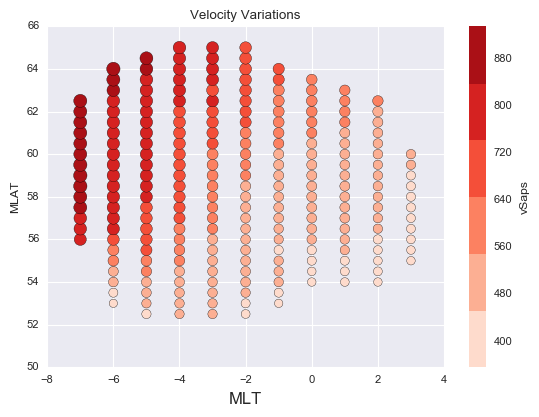

In [20]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

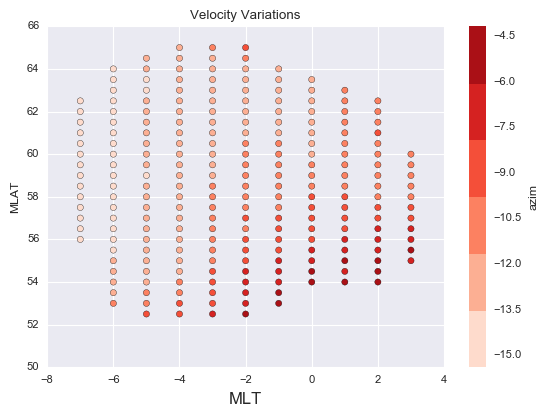

In [21]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

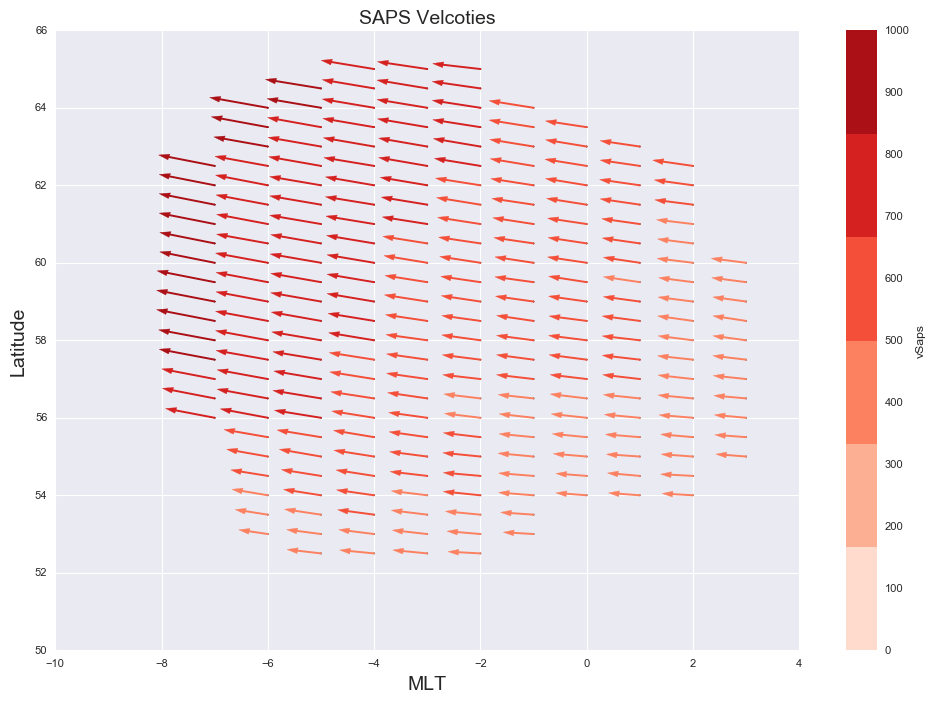

In [22]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
mltMlatMeanDF["plot_MLATEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["MLAT"], 2)
mltMlatMeanDF["plot_normMLTEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["normMLT"], 2)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (mltMlatMeanDF["vSaps"].max() + 100.)*100/100\
    - (mltMlatMeanDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_xlabel("MLT", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title( "SAPS Velcoties", fontsize=14 )



plotMLTends = mltMlatMeanDF['plot_normMLTEnd'].tolist()
plotMLATends = mltMlatMeanDF['plot_MLATEnd'].tolist()
plotMLTbegins = mltMlatMeanDF['normMLT'].tolist()
plotMLATbegins = mltMlatMeanDF['MLAT'].tolist()
plotVelMagns = mltMlatMeanDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
plt.savefig("../figs/mltMlatVelVecs.pdf",bbox_inches='tight')        

In [23]:
# Groupby Dst bin
dstLocDF = velsDataDF.groupby( [ "dst_bin", "normMLT", "MLAT" ] ).mean().reset_index()
dstLocDF.head()

,dst_bin,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,tmStr,dst_index,AE,AL,AO,AU,count
0,"(-10, 10]",-7,59.0,750.020000,-15.560000,2.880000,8.230000,326.000000,9.000000,820.000000,-508.000000,-98.000000,312.00,441
1,"(-10, 10]",-7,60.0,639.425000,-14.300000,3.562500,8.725000,294.500000,8.750000,936.500000,-605.250000,-137.250000,331.25,488
2,"(-10, 10]",-7,60.5,558.570000,-10.620000,2.790000,8.625000,262.000000,8.500000,1037.000000,-669.000000,-151.000000,368.00,507
3,"(-10, 10]",-7,61.0,693.113333,-15.190000,3.786667,5.776667,212.666667,8.000000,984.666667,-599.666667,-107.666667,385.00,451
4,"(-10, 10]",-7,61.5,695.155455,-16.781818,6.124545,9.850000,238.727273,8.181818,833.090909,-501.090909,-84.818182,332.00,400


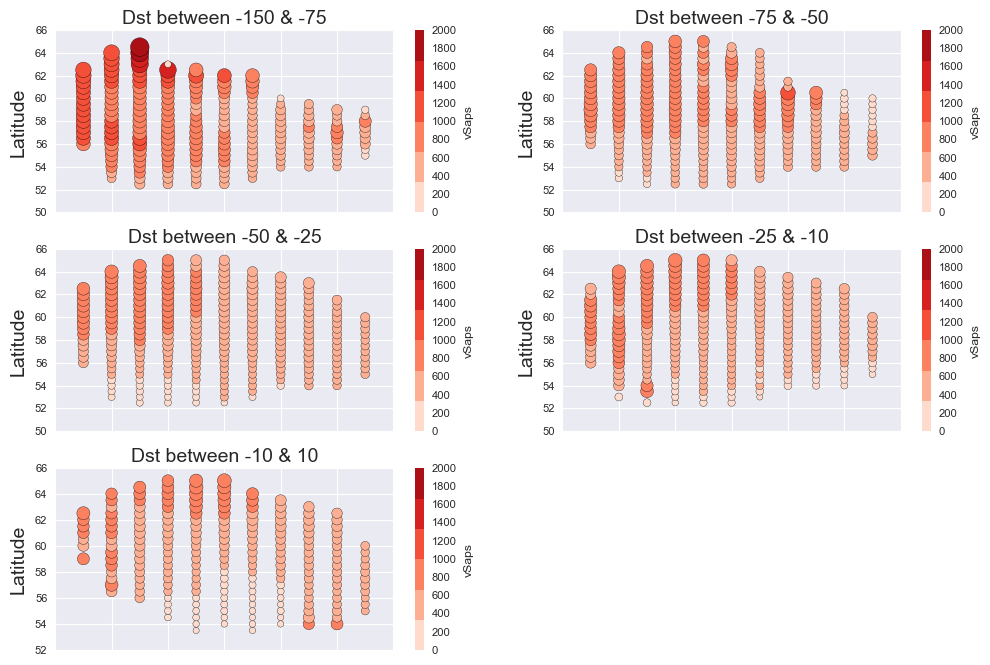

In [24]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
dstSapsMLTLat15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat15075["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat7550["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat5025["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat2510["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat1010["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVels.pdf",bbox_inches='tight')

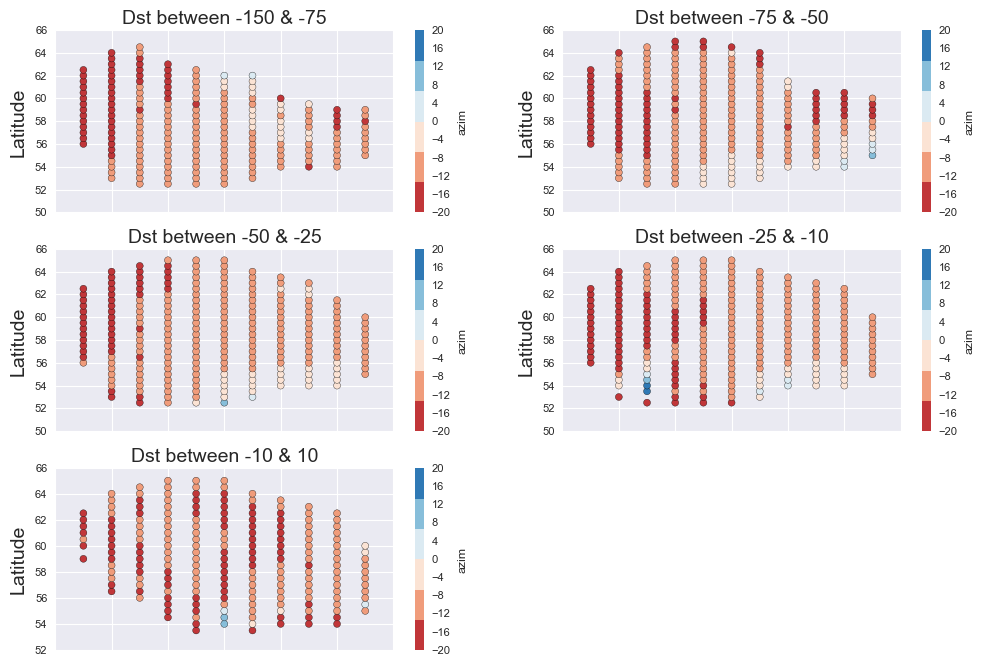

In [25]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# (-150,-75]
dstSapsMLTLat15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=20, vmax=-20, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=20, vmax=-20, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=20, vmax=-20, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=20, vmax=-20, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, vmin=20, vmax=-20, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVels.pdf",bbox_inches='tight')

In [26]:
# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
dstLocDF["plot_MLATEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["MLAT"], 2)
dstLocDF["plot_normMLTEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["normMLT"], 2)

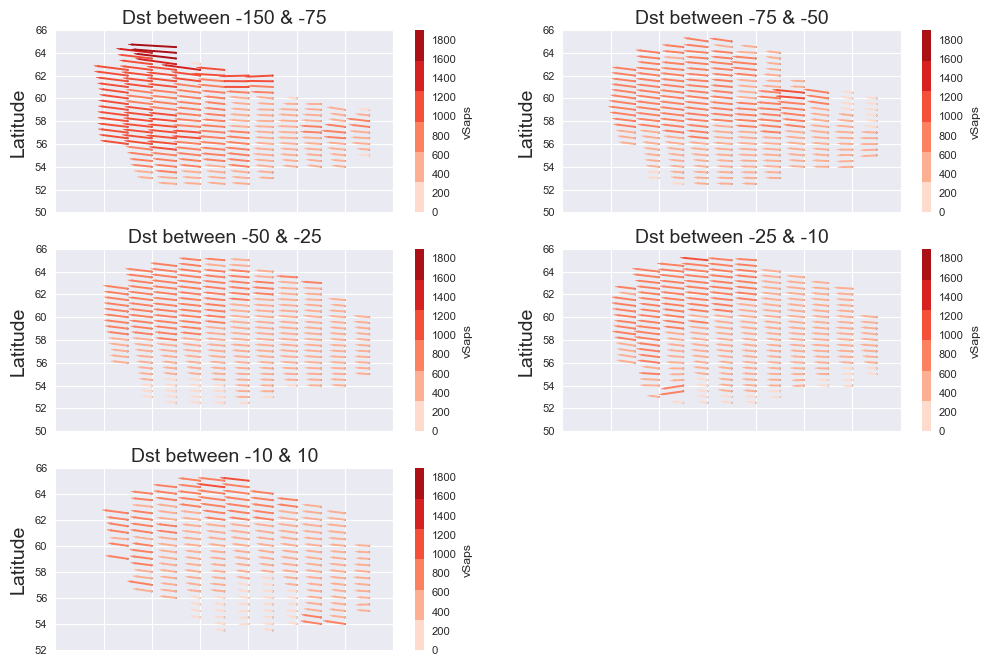

In [28]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (dstLocDF["vSaps"].max() + 100.)*100/100\
    - (dstLocDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF15075['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF7550['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF5025['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF2510['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        

ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF1010['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVelVecs.pdf",bbox_inches='tight')